# Adam: Exercise

For this exercise we will be build Adam up from scratch starting with regular gradient descent. We will also be utilizing mini batches to introduce stochasticity to the optimization. 

We will be working with the mnist_784 data set and a simple shallow neural network. 

If you do not have scikit-learn then you can get it here: https://scikit-learn.org/stable/install.html

This code is heavily inspired by Doug’s code from CSCI 447/547 lecture 05_multilayer_perceptron.

First we need to get the data, define the network and define some functions to perform on the data. You don’t need to do anything with this first block of code. 

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# In order to run this in class, we're going to reduce the dataset by a factor of 5
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X[::5]
y = y.astype(int)[::5]
X, X_test, y, y_test = train_test_split(X, y)

# Here we specify the size of our neural network.
# We are mapping from 784 to 10 with 256 hiden layer nodes.

m = len(X)
n_0 = 784
n_1 = 256
N = 10


# Function to convert categorical labels into one-hot matrix.
def convert_to_one_hot(y, n_classes):
    T = np.zeros((y.shape[0], n_classes))
    for t, yy in zip(T, y):
        t[yy] = 1
    return T


# Convert the data to one hot notation
one_hot_y_actual = convert_to_one_hot(y, N)
one_hot_y_test = convert_to_one_hot(y_test, N)


# Sigmoid function (activation)
def sigmoid(a):
    return 1. / (1 + np.exp(-a))


# Softmax function (final layer for classification)
def softmax(A):
    numerator = np.exp(A)
    denominator = numerator.sum(axis=1)
    return numerator / denominator[:, np.newaxis]


# Categorical cross-entropy
def L(T, S, W1, W2, alpha_1=1e-2, alpha_2=1e-5):
    return -1. / len(T) * np.sum(T * np.log(S)) + np.sum(0.5 * alpha_1 * W1 ** 2) + np.sum(0.5 * alpha_2 * W2 ** 2)


# Run the neural network forward, given some weights and biases
def feedforward(X, W1, W2, b1, b2):
    # Feedforward
    A1 = X @ W1 + b1
    Z1 = sigmoid(A1)
    A2 = Z1 @ W2 + b2
    y_pred = softmax(A2)
    return y_pred, Z1


# Compute the neural network gradients using backpropagation
def backpropogate(y_pred, Z1, X, y_obs, alpha_1=1e-2, alpha_2=1e-5):
    # Backpropogate
    delta_2 = (1. / len(y_pred)) * (y_pred - y_obs)
    grad_W2 = Z1.T @ delta_2 + alpha_2 * W2
    grad_b2 = delta_2.sum(axis=0)

    delta_1 = delta_2 @ W2.T * Z1 * (1 - Z1)
    grad_W1 = X.T @ delta_1 + alpha_1 * W1
    grad_b1 = delta_1.sum(axis=0)
    return grad_W1, grad_W2, grad_b1, grad_b2


def mini_batch(x_sample, y_sample, start_batch_size):
    """
    Takes a copy of x_sample and y_sample and returns mini batch matrices of both and number of batches
    """

    # Batches must divide evenly into total number of samples for numpy arrays to be happy.
    # Gets number of bathes by finding next smallest number that evenly divides
    num_batches = start_batch_size
    while len(x_sample) % num_batches != 0:
        num_batches -= 1

    # randomly shuffle indices
    np.random.seed(42)
    random_indices = np.random.choice(range(len(x_sample)), len(x_sample), replace=False)

    # instantiate lists to hold batches
    x_list = [[] for i in range(num_batches)]
    y_list = [[] for i in range(num_batches)]

    # populate batches matrix with random mini batch indices
    for i in range(len(x_sample)):

        x_list[i // 105].append(x_sample[random_indices[i]])
        y_list[i // 105].append(y_sample[random_indices[i]])
    
    # Convert to numpy arrays
    x_batch = np.array(x_list)
    y_batch = np.array(y_list)

    return x_batch, y_batch, num_batches, num_batches


# Vanilla Gradient Descent

For our first exercise we will implement plain old gradient descent. The mathematical formula is:

$$ \theta_t = \theta_{t-1} - \alpha \nabla f(\theta_{t-1}) \tag{1}$$
---

We have already specified initial values for the $\alpha$ and the batch size but feel free to play around with it. The location to insert your gradient descent implementation is outlined with a multi-line comment.  

In [2]:
"""
Vanilla Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
vanilla_loss = []

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)
        
        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        W1 -= eta*grad_W1
        W2 -= eta*grad_W2
        b1 -= eta*grad_b1
        b2 -= eta*grad_b2


    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    vanilla_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.305485 Accuracy 0.095143
Epoch 10 Loss 2.296722 Accuracy 0.095143
Epoch 20 Loss 2.287348 Accuracy 0.095143
Epoch 30 Loss 2.276909 Accuracy 0.128000
Epoch 40 Loss 2.265160 Accuracy 0.189429
Epoch 50 Loss 2.251949 Accuracy 0.233714
Epoch 60 Loss 2.237195 Accuracy 0.373429
Epoch 70 Loss 2.220911 Accuracy 0.504286
Epoch 80 Loss 2.203200 Accuracy 0.572000
Epoch 90 Loss 2.184210 Accuracy 0.613429
Epoch 100 Loss 2.164103 Accuracy 0.633714
Epoch 110 Loss 2.143041 Accuracy 0.636857
Epoch 120 Loss 2.121186 Accuracy 0.637143
Epoch 130 Loss 2.098684 Accuracy 0.636000
Epoch 140 Loss 2.075672 Accuracy 0.636286
Epoch 150 Loss 2.052271 Accuracy 0.636571


KeyboardInterrupt: 

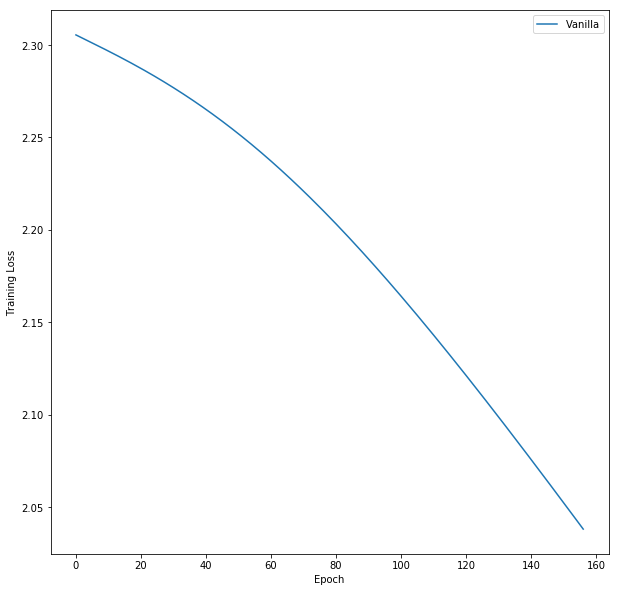

In [4]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Momentum Gradient Descent

Next we will add momentum. The the new update rule is:

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$ \beta_1 \in [0,1)$$
---

$$\theta_{t}=\theta_{t-1} - \alpha m_{t} \tag{2}$$
---

In [9]:

"""
Momentum Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
"""
You need to add another hyper parameter here. Hint! look at the equation above
"""

# data for analysis
momentum_loss = []

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

"""
You probably need to initialize your momentum here... 
"""
beta = .5
M1 = np.zeros((n_0,n_1))
M2 = np.zeros((n_1,N))
Mb1 = np.zeros(n_1)
Mb2 = np.zeros(N)

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        M1 = beta*M1 + (1-beta)*grad_W1 
        M2 = beta*M2 + (1-beta)*grad_W2
        Mb1 = beta*Mb1 + (1-beta)*grad_b1
        Mb2 = beta*Mb2 + (1-beta)*grad_b2 
        
        W1 -= eta*M1
        W2 -= eta*M2
        b1 -= eta*Mb1
        b2 -= eta*Mb2


    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    momentum_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.305494 Accuracy 0.095143
Epoch 10 Loss 2.296731 Accuracy 0.095143
Epoch 20 Loss 2.287360 Accuracy 0.095143
Epoch 30 Loss 2.276924 Accuracy 0.127714
Epoch 40 Loss 2.265179 Accuracy 0.189429
Epoch 50 Loss 2.251973 Accuracy 0.234000
Epoch 60 Loss 2.237223 Accuracy 0.372286
Epoch 70 Loss 2.220943 Accuracy 0.503714
Epoch 80 Loss 2.203236 Accuracy 0.571714
Epoch 90 Loss 2.184251 Accuracy 0.613429
Epoch 100 Loss 2.164147 Accuracy 0.633714
Epoch 110 Loss 2.143089 Accuracy 0.636571
Epoch 120 Loss 2.121236 Accuracy 0.637143
Epoch 130 Loss 2.098736 Accuracy 0.636000
Epoch 140 Loss 2.075726 Accuracy 0.636286
Epoch 150 Loss 2.052327 Accuracy 0.636571
Epoch 160 Loss 2.028645 Accuracy 0.637714
Epoch 170 Loss 2.004789 Accuracy 0.638571
Epoch 180 Loss 1.980861 Accuracy 0.642000
Epoch 190 Loss 1.956931 Accuracy 0.643429
Epoch 200 Loss 1.933058 Accuracy 0.646000
Epoch 210 Loss 1.909294 Accuracy 0.648857
Epoch 220 Loss 1.885682 Accuracy 0.651714
Epoch 230 Loss 1.862261 Accuracy 0.656000
Epo

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# RMSProp Gradient Descent 

Next we will do RMSProp. The update rule is as follows:

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$ \beta_2 \in [0,1)$$
---

$$\theta_{t} = \theta_{t-1} - \alpha \frac { \nabla f(\theta_{t-1})}{\sqrt{v_{t} + \epsilon}} \tag{3}$$ 
---


In [10]:
"""
RMSProp Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
"""
You need to add two hyper parameters here. Hint! look at the equation above
"""


# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
RMS_loss = []

"""
You probably need to initialize your variance here...
"""
beta2 = .9
epsilon = 1e-8
vW1 = np.zeros((n_0,n_1))
vW2 = np.zeros((n_1,N))
vb1 = np.zeros(n_1)
vb2 = np.zeros(N)

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        vW1 = vW1*beta2 + (1-beta2)*(grad_W1**2)
        vW2 = vW2*beta2 + (1-beta2)*(grad_W2**2)
        vb1 = vb1*beta2 + (1-beta2)*(grad_b1**2)
        vb2 = vb2*beta2 + (1-beta2)*(grad_b2**2)
        
        W1 -= eta*grad_W1/np.sqrt(vW1 + epsilon)
        W2 -= eta*grad_W2/np.sqrt(vW2 + epsilon)
        b1 -= eta*grad_b1/np.sqrt(vb1 + epsilon)
        b2 -= eta*grad_b2/np.sqrt(vb2 + epsilon)

       

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    RMS_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.190878 Accuracy 0.555429
Epoch 10 Loss 1.412134 Accuracy 0.865429
Epoch 20 Loss 0.894033 Accuracy 0.888857
Epoch 30 Loss 0.596558 Accuracy 0.902571
Epoch 40 Loss 0.430691 Accuracy 0.907429
Epoch 50 Loss 0.333946 Accuracy 0.912286
Epoch 60 Loss 0.273054 Accuracy 0.917714
Epoch 70 Loss 0.231462 Accuracy 0.920571
Epoch 80 Loss 0.201149 Accuracy 0.923714
Epoch 90 Loss 0.177896 Accuracy 0.926000
Epoch 100 Loss 0.159563 Accuracy 0.929143
Epoch 110 Loss 0.144549 Accuracy 0.929429
Epoch 120 Loss 0.132066 Accuracy 0.930571
Epoch 130 Loss 0.121486 Accuracy 0.931714
Epoch 140 Loss 0.112380 Accuracy 0.932571
Epoch 150 Loss 0.104411 Accuracy 0.932857
Epoch 160 Loss 0.097409 Accuracy 0.934286
Epoch 170 Loss 0.091203 Accuracy 0.934286
Epoch 180 Loss 0.085590 Accuracy 0.933714
Epoch 190 Loss 0.080617 Accuracy 0.933429
Epoch 200 Loss 0.076156 Accuracy 0.933429
Epoch 210 Loss 0.072105 Accuracy 0.932286
Epoch 220 Loss 0.068348 Accuracy 0.932286
Epoch 230 Loss 0.064923 Accuracy 0.932286
Epo

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Adam Gradient Descent 

Now we put them both together and we get Adam!

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$\hat m_{t} = \frac {m_{t}}{1 - \beta_1^{t}}$$
---

$$\hat v_t = \frac {v_{t}}{1 - \beta_2^{t}}$$
---

$$\theta_t = \theta_{t-1} - \alpha \frac {\hat m_t}{\sqrt{\hat v_t + \epsilon}} \tag{4}$$
---

Play around with the hyperparameters to see if you can get distinctly different behavior from the optimization.

In [5]:
"""
Adam Gradient Descent
"""

# Hyper Parameters
eta = 1e-3
initial_batch_size = 104
epochs = 250
"""
You need to add 3 hyper parameters here. Hint! look at the equation above
"""
epsilon = 1e-8
beta1 = .9
beta2 = .99

vW1 = np.zeros((n_0,n_1))
vW2 = np.zeros((n_1,N))
vb1 = np.zeros(n_1)
vb2 = np.zeros(N)

M1 = np.zeros((n_0,n_1))
M2 = np.zeros((n_1,N))
Mb1 = np.zeros(n_1)
Mb2 = np.zeros(N)

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
Adam_loss = []

"""
You probably need to initialize your variance and momentum here...
"""


# Perform gradient descent
count = 1
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])
        
        M1 = beta1*M1 + (1-beta1)*grad_W1 
        M2 = beta1*M2 + (1-beta1)*grad_W2
        Mb1 = beta1*Mb1 + (1-beta1)*grad_b1
        Mb2 = beta1*Mb2 + (1-beta1)*grad_b2
        
        vW1 = vW1*beta2 + (1-beta2)*(grad_W1**2)
        vW2 = vW2*beta2 + (1-beta2)*(grad_W2**2)
        vb1 = vb1*beta2 + (1-beta2)*(grad_b1**2)
        vb2 = vb2*beta2 + (1-beta2)*(grad_b2**2)
        
        m1_hat = M1/(1-beta1**count)
        m2_hat = M2/(1-beta1**count)
        mb1_hat = Mb1/(1-beta1**count)
        mb2_hat = Mb2/(1-beta1**count)
        
        v1_hat = vW1/(1-beta2**count)
        v2_hat = vW2/(1-beta2**count)
        vb1_hat = vb1/(1-beta2**count)
        vb2_hat = vb2/(1-beta2**count)
        
        W1 -= eta*m1_hat/np.sqrt(v1_hat + epsilon)
        W2 -= eta*m2_hat/np.sqrt(v2_hat + epsilon)
        b1 -= eta*mb1_hat/np.sqrt(vb1_hat + epsilon)
        b2 -= eta*mb2_hat/np.sqrt(vb2_hat + epsilon)
        count += 1
        
        
        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """

        

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    Adam_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.199524 Accuracy 0.460286
Epoch 10 Loss 1.411599 Accuracy 0.876000
Epoch 20 Loss 0.900433 Accuracy 0.898000
Epoch 30 Loss 0.602088 Accuracy 0.908857
Epoch 40 Loss 0.432437 Accuracy 0.916286
Epoch 50 Loss 0.331789 Accuracy 0.922857
Epoch 60 Loss 0.267299 Accuracy 0.925714
Epoch 70 Loss 0.223130 Accuracy 0.929143
Epoch 80 Loss 0.191206 Accuracy 0.929429
Epoch 90 Loss 0.166953 Accuracy 0.930286
Epoch 100 Loss 0.147634 Accuracy 0.929714
Epoch 110 Loss 0.132000 Accuracy 0.930857
Epoch 120 Loss 0.119165 Accuracy 0.931143
Epoch 130 Loss 0.108405 Accuracy 0.932286
Epoch 140 Loss 0.099183 Accuracy 0.932000
Epoch 150 Loss 0.091270 Accuracy 0.932571
Epoch 160 Loss 0.084350 Accuracy 0.934000
Epoch 170 Loss 0.078212 Accuracy 0.933714
Epoch 180 Loss 0.072878 Accuracy 0.933429
Epoch 190 Loss 0.068158 Accuracy 0.932857
Epoch 200 Loss 0.063935 Accuracy 0.933714
Epoch 210 Loss 0.060178 Accuracy 0.933714
Epoch 220 Loss 0.056706 Accuracy 0.934000
Epoch 230 Loss 0.053560 Accuracy 0.933714
Epo

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.plot(Adam_loss, label='Adam')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

In [ ]:
"""
AdaMax Gradient Descent
"""

# Hyper Parameters
eta = 2e-3
initial_batch_size = 104
epochs = 250
"""
You need to add 3 hyper parameters here. Hint! look at the equation above
"""
epsilon = 1e-8
beta1 = .9
beta2 = .99

vW1 = 0
vW2 = 0
vb1 = 0
vb2 = 0

M1 = np.zeros((n_0,n_1))
M2 = np.zeros((n_1,N))
Mb1 = np.zeros(n_1)
Mb2 = np.zeros(N)

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
Ada_max_loss = []

"""
You probably need to initialize your variance and momentum here...
"""


# Perform gradient descent
count = 1
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])
        
        M1 = beta1*M1 + (1-beta1)*grad_W1 
        M2 = beta1*M2 + (1-beta1)*grad_W2
        Mb1 = beta1*Mb1 + (1-beta1)*grad_b1
        Mb2 = beta1*Mb2 + (1-beta1)*grad_b2
        
        vW1 = np.max([beta2*vW1,np.max(np.abs(grad_W1))])
        vW2 = np.max([beta2*vW2,np.max(np.abs(grad_W2))])
        vb1 = np.max([beta2*vb1,np.max(np.abs(grad_b1))])
        vb2 = np.max([beta2*vb2,np.max(np.abs(grad_b2))])
        
      
        
        W1 -= (eta*M1/vW1)/(1-beta1**count)
        W2 -= (eta*M2/vW2)/(1-beta1**count)
        b1 -= (eta*Mb1/vb1)/(1-beta1**count)
        b2 -= (eta*Mb2/vb2)/(1-beta1**count)
        count += 1
        
        
        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """

        

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    Ada_max_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 0.624618 Accuracy 0.890571
Epoch 10 Loss 0.120499 Accuracy 0.940286
Epoch 20 Loss 0.058756 Accuracy 0.949143
Epoch 30 Loss 0.032706 Accuracy 0.950286
Epoch 40 Loss 0.021468 Accuracy 0.952571
Epoch 50 Loss 0.014572 Accuracy 0.954286
Epoch 60 Loss 0.010510 Accuracy 0.954000
Epoch 70 Loss 0.009532 Accuracy 0.953714
Epoch 80 Loss 0.009855 Accuracy 0.951429
Epoch 90 Loss 0.010370 Accuracy 0.953143
Epoch 100 Loss 0.020701 Accuracy 0.950000
Epoch 110 Loss 0.009277 Accuracy 0.956000


In [8]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.plot(Adam_loss, label='Adam')
plt.plot(Ada_max_loss,label='Ada-max')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

NameError: name 'vanilla_loss' is not defined